In [2]:
import torch
from pathlib import Path
from pydicom import dcmread
from PIL import Image
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from joblib import Parallel, delayed
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# TO DO: 



###### Use Grad-CAM or heatmap visualization to interpret model focus.

###### Implement data augmentation early to reduce overfitting.

###### Downsample images to 224×224 or 256×256 to save resources without performance loss.



###### Use sklearn train test split to split the data into train and validation set

###### Also address the class imbalance

###### More EDA on the Data---graphs and tables to show the data stuff and training decision made based on that

###### Image Augmentation to increase the data samples



###### Train the model again after completing all of the above steps for up to 100 epochs
###### In the mean time also look for more powerful computer to train the model on


###### Heatmap after the model has been trained.....to see where the model mostly localizes its predication ....and comapre it with the initial heatmap of the label bbox data


###### PA and AP view also plays a huge role in how the model will train.....

### Load the label file with bbox labels and detail_class_info label file 

In [3]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'

label_file_df = pd.read_csv(label_file_path)
class_info_df = pd.read_csv('data/pneumonia_dataset/stage_2_detailed_class_info.csv')

In [4]:
# concat the two dataframe on the basis of `patientId`
df = pd.concat([label_file_df, class_info_df['class']], axis=1)

In [5]:
df.sample(10)

,patientId,x,y,width,height,Target,class
3548,390dad2f-bd13-4f16-92af-4e061499eddc,587.0,199.0,228.0,373.0,1,Lung Opacity
5166,44bdfd06-2293-4d2a-997e-81153a2808db,NaN,NaN,NaN,NaN,0,Normal
12288,7dc00dd4-ad6f-4fee-9e47-3f2b4b88d3ea,756.0,521.0,196.0,101.0,1,Lung Opacity
5840,4a0de7be-7db0-4742-8a6d-ea17656ad3bf,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
20745,bd0b7f64-8ae8-48c7-8753-aa128fd773ec,NaN,NaN,NaN,NaN,0,Normal
11493,7759e7ae-641f-4504-b373-95a8763dc59a,687.0,314.0,95.0,128.0,1,Lung Opacity
9324,66830592-46b6-4907-9c06-845338b63fa2,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
27265,f248f5a2-490d-4711-9ae7-6c9b14beab2e,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
856,0af9ad69-4d76-4de9-b93a-294478a97866,657.0,313.0,211.0,447.0,1,Lung Opacity
18199,ac4bf897-0752-4095-9404-1e6ff42a1dfb,153.0,137.0,243.0,632.0,1,Lung Opacity


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


### Handle Missing Data
The `0` or `no pneumonia` class has no bbox data so we only need to handle missing data for the `1` or `pneumonia` class

In [7]:
df

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


In [8]:
# The `x`, `y`, `width` and `height` columns for Target 0 are excepted to have missing value indicating no bbox
missing_data = df.isna().sum()
print(f'Number of missing values per columns:\n{missing_data}')

Number of missing values per columns:
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64


In [9]:
# Check missing data exclusisvley for Target class 1
present_df = df[df.Target == 1]
missing_data_pres = present_df.isna().sum()
print(f'Number of missing values per columns:\n{missing_data_pres}')

Number of missing values per columns:
patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64


### Check the class Distribution in the data

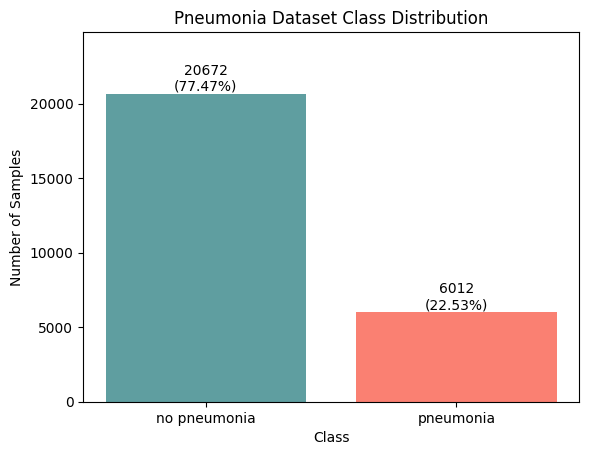

In [10]:
# Number of Data samples with pneumonia and without pneumonia

counts = df.drop_duplicates('patientId')['Target'].value_counts()

# num_no_pneumonia = counts[0]
# num_pneumonia = counts[1]

data_class = {
    'no pneumonia': int(counts.get(0, 0)),
    'pneumonia': int(counts.get(1, 0))
}

total = sum(data_class.values())


bars = plt.bar(data_class.keys(), data_class.values(), color=['cadetblue', 'salmon'])
plt.bar_label(bars, labels=[f"{value}\n({value/total*100:.2f}%)" for value in data_class.values()])
plt.ylim(0, 1.2*max(data_class.values()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Dataset Class Distribution')
plt.show()

In [11]:
# Create a dictionary with all the classes and their corresponding value(occurance in the label)
# count = df.drop_duplicates('patientId')['class'].value_counts()
count = df['class'].value_counts()

data_class_detail = count.keys()

data_num_obj = {}


for x in range(len(count)):
    entry = {data_class_detail[x]: count.iloc[x].item()}
    data_num_obj.update(entry)

data_num_obj

{'No Lung Opacity / Not Normal': 11821, 'Lung Opacity': 9555, 'Normal': 8851}

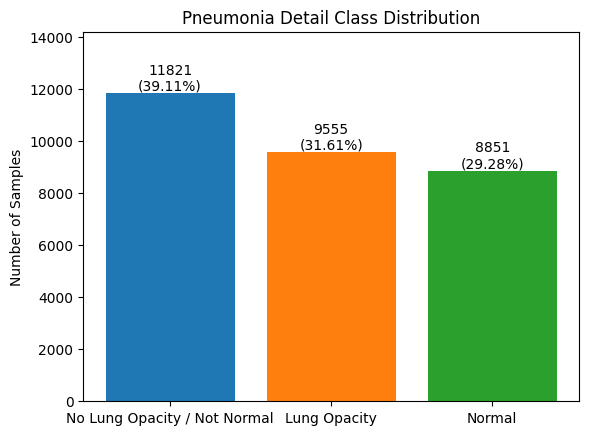

In [12]:
color = sns.color_palette('tab10', n_colors=len(data_num_obj))

total = sum(count.values).item()

bar = plt.bar(data_num_obj.keys(), data_num_obj.values(), color=color)

plt.bar_label(bar, labels=[f'{values}\n({(values/total)*100:.2f}%)' for values in data_num_obj.values()])
plt.ylim(0, 1.2*max(data_num_obj.values()))
# plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Detail Class Distribution')
plt.show()

RSNA Pneumonia Detection - (3-Class Label Explanation):
* 'Lung Opacity'                 --> Pneumonia or similar lung opacity (positive case)
* 'Normal'                       --> Completely normal chest X-ray (no abnormal findings)
* 'No Lung Opacity / Not Normal' --> Abnormal chest X-ray, but NOT pneumonia (e.g., cardiomegaly, effusion, etc.)

This labeling helps distinguish pneumonia from both normal and other non-pneumonia abnormalities.

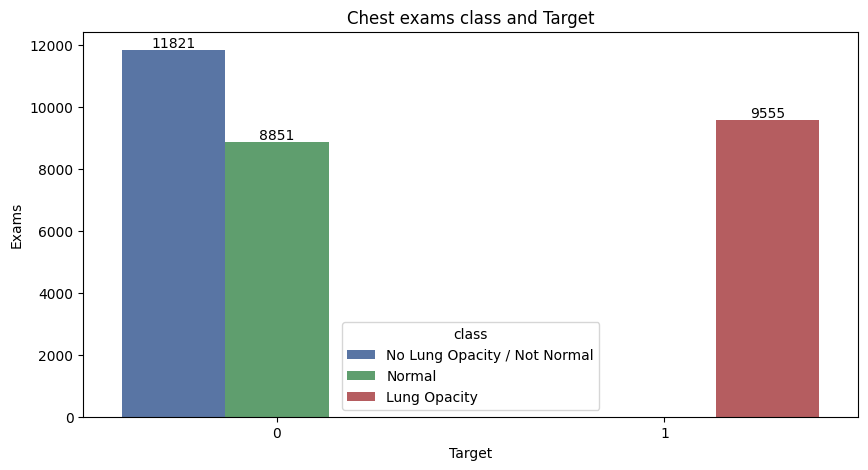

In [13]:
fig, ax = plt.subplots(nrows=1,figsize=(10,5))
tmp = df.groupby('Target')['class'].value_counts()
temp_df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
ax = sns.barplot(ax=ax,x ='Target', y='Exams',hue='class',data=temp_df, palette = ['#4C72B0', '#55A868', '#C44E52'])

for container in ax.containers:
    ax.bar_label(container, fmt='%d')


plt.title("Chest exams class and Target")
plt.show()

### Funtion to print the data images with bbox(if any)

In [14]:
class_str = list(data_class.keys())

def print_sample(sample_images, rows, columns):

    fig, axes = plt.subplots(rows, columns, figsize=(9, 9))
    axes = axes.flatten() # flatten the axis form 2D to 1D making it easier to index over it

    total_subplots = rows * columns

    # print(sample_images)
    

    for idx in range(min(len(sample_images), total_subplots)): # Limit the display to just rows*columns images
        Id = sample_images.iloc[idx]
        dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
        dcm_file_data = dcmread(dcm_file_path)
        pixel_data = dcm_file_data.pixel_array

        
        axes[idx].imshow(pixel_data, cmap='grey')
        axes[idx].axis(False)

        # Get all the data columns for the instance of the Id
        all_instance = df[df['patientId'] == Id]
        class_label = all_instance.iloc[0].Target

        if  class_label == 1:
            
            for x in range(len(all_instance)):
                col_data = all_instance.iloc[x]
            
                # Print Bounding Box if the pneumonia present
                x, y, width, height, =  col_data.x, col_data.y, col_data.width, col_data.height
                rect = Rectangle((x, y), width, height, facecolor='none', edgecolor='red', lw=2)
                axes[idx].add_patch(rect)

        # Set Title color according to class
        color = 'green' if class_label == 0 else 'red'

        # Set titel to the patient Id and the status of the present of pneumonia or not
        # axes[idx].set_title(f'Patient Id: {Id}, {class_label}', fontsize=9, color=color)
        axes[idx].set_title(f'{class_str[class_label]}', fontsize=12, color=color)

    plt.tight_layout()

    # Hide any unused subplots
    for j in range(len(sample_images), total_subplots):
        axes[j].axis('off')

### Print some of the pneumonia and no pneumonia images form the dataset

In [15]:
pneu_df = df[df.Target == 1]
no_pneu_df = df[df.Target == 0]

pneu_present_sample = pneu_df.sample(9).patientId
pneu_not_present_sample = no_pneu_df.sample(9).patientId

# all_class_sample = pd.concat([pneu_present_sample, pneu_not_present_sample])

# all_class_sample = all_class_sample.sample(frac=1)

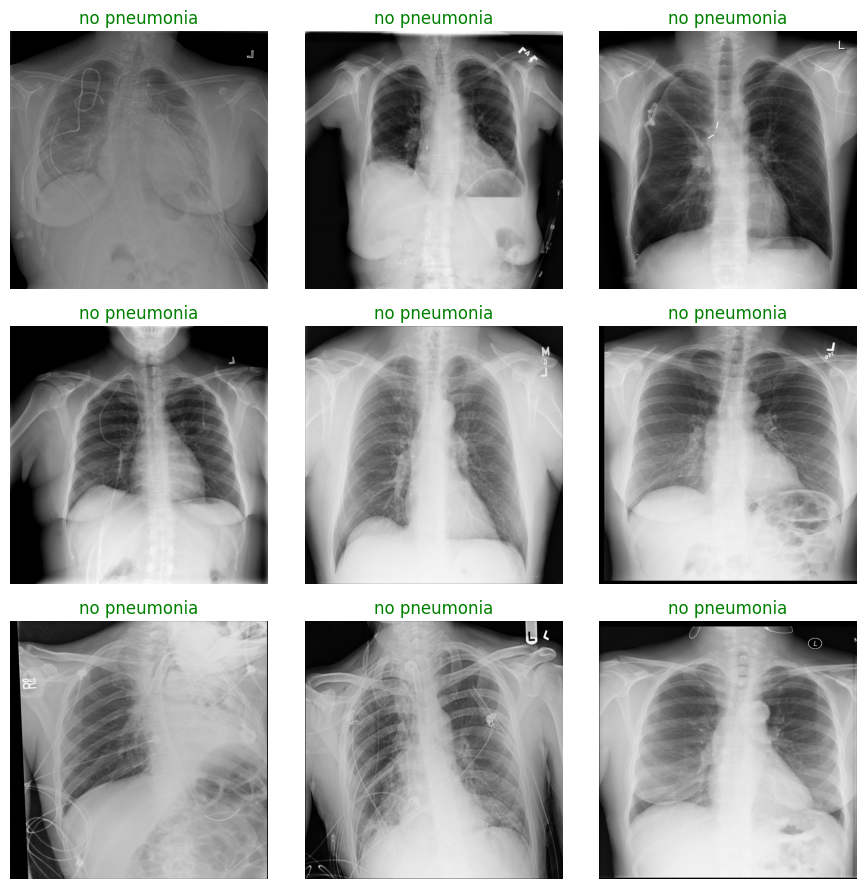

In [16]:
print_sample(pneu_not_present_sample, rows=3, columns=3)

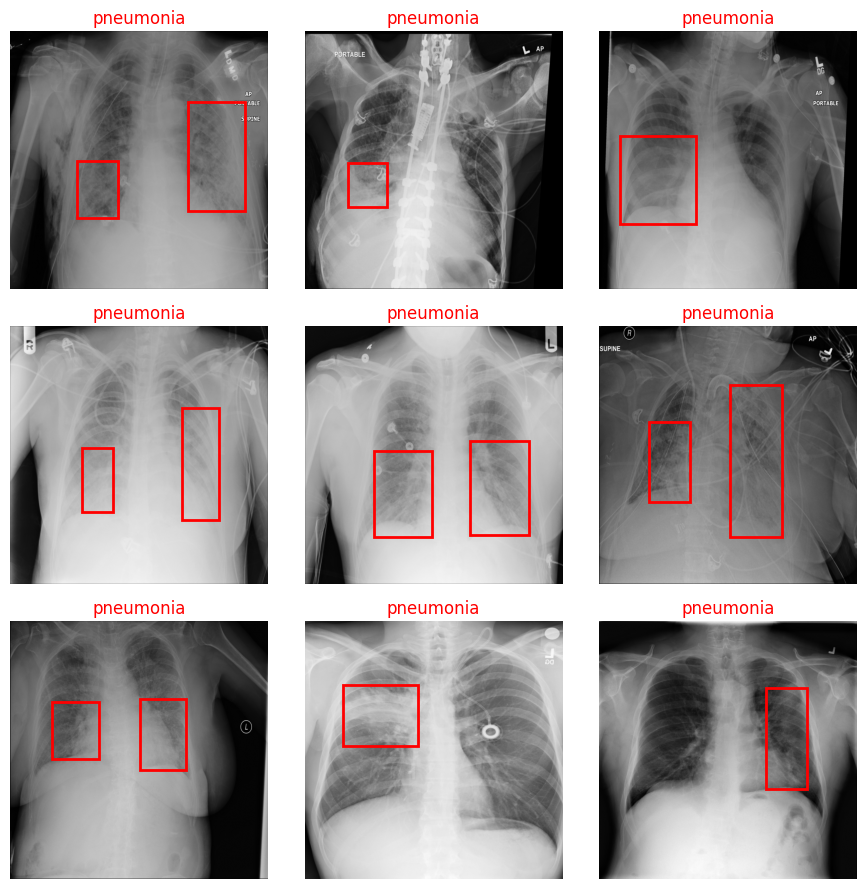

In [17]:
print_sample(pneu_present_sample, rows=3, columns=3)

### Check the distribution of disease(for case that have pneumonia) by Age and Sex
### Then Plot a histogram to show the distribtuion across these Variables(age and sex)
Try a bunch of range for the histogram for the proper insight
(Refer to the statQuest Histogram video if confused about the Histogram)

In [18]:
dcm_metadata = df.patientId
dcm_metadata = pd.DataFrame(dcm_metadata)

dcm_metadata['age'] = None
dcm_metadata['sex'] = None

Id_list = dcm_metadata.patientId

In [19]:
# Use parallel processing via `joblib` library to read the dcm meta-data faster

def patient_age_data(Id):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
    dcm_file = dcmread(dcm_file_path, stop_before_pixels=True)
    return int(dcm_file.PatientAge)

def patient_sex_data(Id):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
    dcm_file = dcmread(dcm_file_path, stop_before_pixels=True)
    return dcm_file.PatientSex

def patient_view_data(Id):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
    dcm_file = dcmread(dcm_file_path, stop_before_pixels=True)
    return  dcm_file.ViewPosition

parallel_obj = Parallel(n_jobs=-1) # n_jobs='-1' if we want to use all the available cpu cores

# return age and sex data list from 
age_data = parallel_obj(delayed(patient_age_data)(Id) for Id in Id_list) 
sex_data = parallel_obj(delayed(patient_sex_data)(Id) for Id in Id_list)
view_data = parallel_obj(delayed(patient_view_data)(Id) for Id in Id_list)

In [20]:
# assign the age and sex data list to the age and sex columns
dcm_metadata['age'] = age_data
dcm_metadata['sex'] = sex_data
dcm_metadata['view'] = view_data

# Check if there are any missing values
dcm_metadata.isna().sum()

patientId    0
age          0
sex          0
view         0
dtype: int64

In [21]:
# merge the inital df and the metadata df into one on 'patientId'
df = pd.concat([df, dcm_metadata['age'], dcm_metadata['sex'], dcm_metadata['view']], axis=1)

In [22]:
# Check for any missing values in the data
df.isna().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
age              0
sex              0
view             0
dtype: int64

In [23]:
# Check unique values in the age data 
age_histogram_data = df.drop_duplicates('patientId').age
age_histogram_data.unique()

array([ 51,  48,  19,  28,  32,  54,  78,  75,  59,  63,   6,  23,  70,
        58,  36,  43,  21,  52,  60,  71,  50,  38,  47,  67,  44,  40,
        56,  53,  31,  49,  14,  68,  42,  57,  41,  62,  15,  29,   2,
        39,  13,  34,  61,  35,  66,  30,   7,   3,  37,  46,  76,  27,
        20,  64,  65,  45,  73,  69,  16,  24,  17,  77,  25,  22,  55,
        74,  18,  33,   9,  87,  26,  10,  12,  86,  72,  79,  83,  81,
        11,  80,  85,   8,  82,   5,  84,  90,  88,   4,  89, 148,   1,
        92, 151, 153,  91, 150, 155])

In [24]:
# since we have age like 155, 151..which dosen't make sense we have to remove these outliers
age_histogram_data.describe()

Q1 = age_histogram_data.quantile(0.25)
Q2 = age_histogram_data.quantile(0.5)
Q3 = age_histogram_data.quantile(0.75)

IQR = Q3 - Q1

print(Q1, Q2, Q3, IQR)

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(lower_limit, upper_limit)

34.0 49.0 59.0 25.0
-3.5 96.5


In [25]:
# all the columns with the outlier age data
df[(df.age > upper_limit)|(df.age < lower_limit)]

,patientId,x,y,width,height,Target,class,age,sex,view
3921,3b8b8777-a1f6-4384-872a-28b95f59bf0d,NaN,NaN,NaN,NaN,0,Normal,148,M,PA
11032,73aeea88-fc48-4030-8564-0a9d7fdecac4,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,151,F,PA
17213,a4e8e96d-93a6-4251-b617-91382e610fab,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,153,M,PA
26488,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,NaN,NaN,NaN,NaN,0,Normal,150,M,PA
27746,f632328d-5819-4b29-b54f-adf4934bbee6,NaN,NaN,NaN,NaN,0,Normal,155,F,PA


In [26]:
# new df with all the outliers removed
no_outlier_df = df[(df.age > lower_limit)&(df.age < upper_limit)]
no_outlier_df.age.unique()

array([51, 48, 19, 28, 32, 54, 78, 75, 59, 63,  6, 23, 70, 58, 36, 43, 21,
       52, 60, 71, 50, 38, 47, 67, 44, 40, 56, 53, 31, 49, 14, 68, 42, 57,
       41, 62, 15, 29,  2, 39, 13, 34, 61, 35, 66, 30,  7,  3, 37, 46, 76,
       27, 20, 64, 65, 45, 73, 69, 16, 24, 17, 77, 25, 22, 55, 74, 18, 33,
        9, 87, 26, 10, 12, 86, 72, 79, 83, 81, 11, 80, 85,  8, 82,  5, 84,
       90, 88,  4, 89,  1, 92, 91])

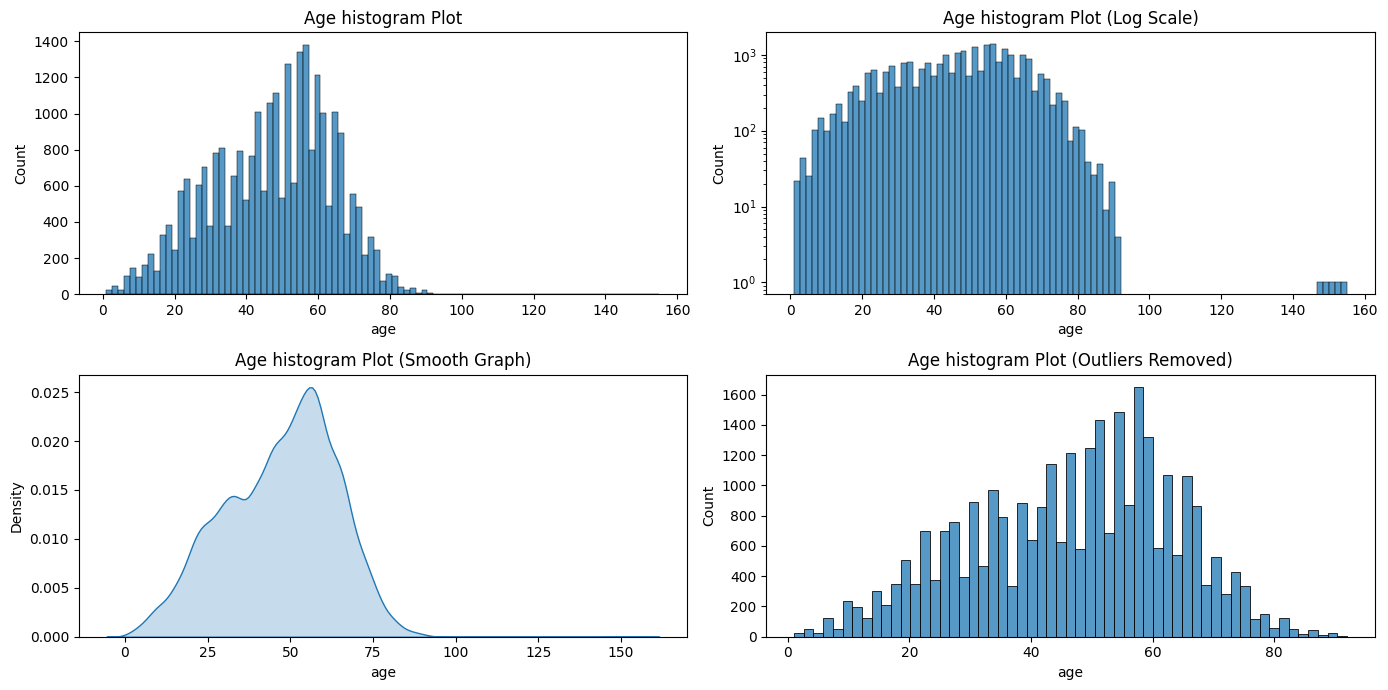

In [27]:
# Plot histograms for the age data

fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.flatten()

sns.histplot(age_histogram_data, ax=axes[0])
axes[0].set_title('Age histogram Plot')

# frequncy data of the age is in log scale to visualize the less occuring age data
sns.histplot(age_histogram_data, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Age histogram Plot (Log Scale)')


sns.kdeplot(age_histogram_data, fill=True, ax=axes[2])
axes[2].set_title('Age histogram Plot (Smooth Graph)')

sns.histplot(no_outlier_df.age, ax=axes[3])
axes[3].set_title('Age histogram Plot (Outliers Removed)')

plt.tight_layout()

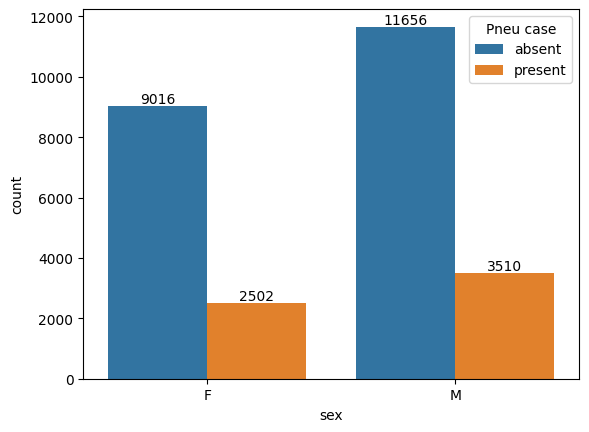

In [28]:
# Drop duplicate patients, group by sex, then count how many patients in each sex group have Target = 0 or 1
tmp = df.drop_duplicates('patientId').groupby('sex')['Target'].value_counts()

# convet this droup by series to dataframe with proper values and index
data_fr = pd.DataFrame(data={'count': tmp.values}, index=tmp.index).reset_index()

# plot the bar with subclass/hue='Target' (0 or 1)
bar = sns.barplot(data=data_fr, x='sex', y='count', hue='Target', legend=True)
handles, labels = bar.get_legend_handles_labels()

plt.legend(handles=handles, labels=['absent', 'present'], title='Pneu case')

for container in bar.containers:
    bar.bar_label(container, fmt='%d')

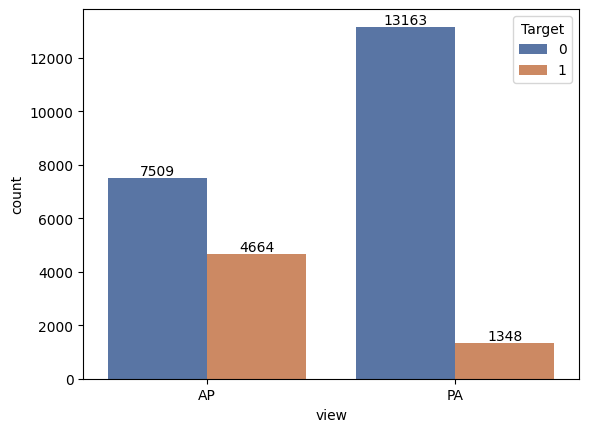

In [29]:
# PA vs AP plot

# count = df.view.value_counts()
count = df.drop_duplicates('patientId').groupby('view')['Target'].value_counts()
view_count = pd.DataFrame(data={'count': count.values}, index=count.index).reset_index()

bar = sns.barplot(data=view_count, x='view', y='count', hue='Target', palette=["#4C72B0", "#DD8452"])
for container in bar.containers:
    bar.bar_label(container, fmt='%d')

### Heat map of the bbox presence

Take the model we have trained now(the best one).....run inference on it and get the return bbox data from it....and plot the heatmap...the heatmap of our trained model (map50 = 0.25) on the final prediciton of the model

For post model evaluation heatmap

Only add to the heatmap when the confiednce score in greater then a ceratin threshold
if confidence_score > threshold:
* .....
* .....
* heatmap[y_min:y_max, x_min:x_max] += 1

Also dont add 1 but rather add the confidence score
if confidence_score > threshold:
* .....
* .....
* heatmap[y_min:y_max, x_min:x_max] += confidence_score


Why we add a confidence score......

If you just add +1 for every predicted box above the threshold, all boxes are treated equally — even if one is 51% confident and another is 99%. But intuitively:

A 99% confidence box should contribute more to the heatmap.

A 51% confidence box might be a borderline false positive — it should contribute less.

By adding the confidence score:

Areas where the model consistently predicts with high confidence will "light up" more.

You get a more nuanced and informative visualization.

Text(0.5, 1.0, 'Bounding Box HeatMap Overlay')

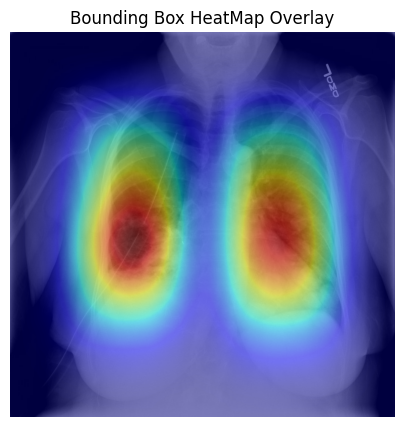

In [30]:
# Get all the labeled data rows (Target = 1) and plot the bbox into the heatmap

# get all the columns data with the bounding box values
target_data = df[df.Target == 1]
bbox_data = target_data.iloc[:, 1: 5]
bbox_data


# Load your image
image = cv2.imread('scan.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create an empty heatmap (same height and width as image)
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

for index, box in bbox_data.iterrows():
    x, y, w, h = box
    x_min, y_min = int(x), int(y)
    x_max, y_max = int(x + w), int(y + h)
    
    # Add 1 to the heatmap area covered by this bbox
    heatmap[y_min:y_max, x_min:x_max] += 1


# Normalize heatmap to 0-1
heatmap /= np.max(heatmap)

# Optional: apply Gaussian blur for smoothness
heatmap = cv2.GaussianBlur(heatmap, (31,31), 0)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis(False)
plt.title('Bounding Box HeatMap Overlay')

### Normalize the bbox coordinates in the dataframe

In [31]:
# Get the height and width data of each image
# Nomralize the bbox data based on this height and width data of the image
# normalize only for the Target = '1' because bbox data is only present for data with pneumonia present





# Use parallel processing via `joblib` library to read the dcm meta-data faster

Id_list_no_dupli = Id_list.drop_duplicates()

def size_data(Id):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
    dcm_file = dcmread(dcm_file_path, stop_before_pixels=True)
    row = dcm_file.Rows
    col = dcm_file.Columns
    return row, col


dim_data = parallel_obj(delayed(size_data)(Id) for Id in Id_list_no_dupli)

In [32]:
# convert the image dim meta-data form the dcm file into a dataframe....we attach this to the original dataframe and normalize the bbox values according to it......
# plan is to take the full height and width of the image size data and use that to normalize the images corresponding bbox data 
img_dim_df = pd.DataFrame(dim_data)
len(img_dim_df)

row = img_dim_df[0].unique()
col = img_dim_df[1].unique()
print(f'Unique values of Row size: {row}')
print(f'Unique values of Column size: {col}')

Unique values of Row size: [1024]
Unique values of Column size: [1024]


In [33]:
# But now we know that all the images in the dataset are in size 1024 * 1024
# So lets noramlize all the  bbox data values by dividing them by 1024

# df = df.copy()

df['x'] = df['x'] / 1024
df['y'] = df['y'] / 1024
df['width'] = df['width'] / 1024
df['height'] = df['height'] / 1024

df

,patientId,x,y,width,height,Target,class,age,sex,view
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,0.257812,0.148438,0.208008,0.370117,1,Lung Opacity,32,F,AP
...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,0.180664,0.291016,0.222656,0.370117,1,Lung Opacity,54,M,AP
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,46,F,PA
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,45,M,PA
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,0.556641,0.383789,0.254883,0.336914,1,Lung Opacity,72,F,AP


### Here are some tips this time around to improve the result with the model
1. Verify Label Quality
* Visualize random samples with bounding boxes.
* Check for tight boxes, accurate positioning, and no false positives.
* Ensure multi-lesion images have multiple boxes.

2. Balance Your Dataset
* Check for class imbalance (e.g., many normal X-rays vs few pneumonia).
* Consider oversampling pneumonia cases.
* Optionally, downsample normal cases or balance batches.

3. Use Image-Level Metadata
* Use DICOM metadata (e.g., ViewPosition, PatientAge) to filter or group data.
* Prefer consistent views (e.g., only PA or AP) to avoid confusing patterns.

4. Data Augmentation
* Use or customize YOLOv8’s built-in augmentations.
* Apply flips, scaling, blur, brightness, and contrast adjustments.
* More aggressive augmentation can help detect small or subtle patterns.

5. Try Larger YOLOv8 Models
* Instead of yolov8n, try yolov8s, yolov8m, or yolov8l depending on GPU capacity.
* Larger models capture more features and improve accuracy.

6. Use Mosaic Augmentation
* Enabled by default in YOLOv8.
* Especially effective for small and sparse objects like pneumonia patches.
* Make sure it's not accidentally turned off.

7. Train Longer & Use Cosine Learning Rate
* Train for 100+ epochs if loss hasn’t plateaued.
* Use a cosine LR schedule for smoother convergence.
* Example: scheduler='cosine', lr0=0.001, lrf=0.01.

8. Evaluate on a Clean Validation/Test Set
* Use a separate, representative validation/test split.
* Run model.val() or model.predict() to evaluate performance.
* Avoid leakage between training and test sets.

9. Filter Out Bad or Corrupt Images
* Check for black images, invalid DICOMs, or low-contrast junk data.
* Remove lateral views or mislabeled cases, if any.

10. (Optional) Handle Grayscale Input Smartly
* X-rays are grayscale, but YOLO expects 3-channel RGB.
* Convert grayscale to 3-channel by duplicating channels.
* Advanced: Modify model input layer to accept 1-channel images (not necessary, but possible).

In [34]:
# Scour internet to possibly find more pneumonia data that u can use to train your model....
# Following are some of the publicly available dataset that contain pnuemonia related data.......future consideration to combine them with the RSNA Pnuemonia dataset.....




# NIH ChestX-ray14
# Large public dataset with multiple disease labels including pneumonia. Mostly image-level labels but some bounding boxes available.

# CheXpert (Stanford)
# Very large, labeled chest X-ray dataset. Has uncertain labels, so careful handling needed.

# MIMIC-CXR
# Huge dataset with chest X-rays and rich metadata from ICU patients. Requires credentialed access.

# COVID-19 X-ray datasets
# Include pneumonia cases (viral pneumonia). Useful for broader pneumonia modeling.

# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

### SPlit the Data into Train and Val Set and Test Set(Stratified Splitting based on Target and view labels)..... 

In [35]:
# Create a stratifiy_column that combines the data form the `Target` and `view`.............we will use this new column to stratigy the group into `train` and `val` so that both the set have balance of both 0 and 1 target class and PA and AP view class....meaning both the class values are distibuted uniformaly acroos both the `train` and `val` set

In [36]:
# If we want to stratify by multiple groups we can create a new columns class(combining these multiple groups) and straftiy on that new column

In [37]:
df['stratify_group'] = (df['Target'].astype(str) + df['view'].astype('str'))

In [38]:
# stratify the data based on this new stratify_group column
no_duplicate_df = df.drop_duplicates('patientId')
train_df, val_df = train_test_split(no_duplicate_df,  train_size=0.8, test_size=0.2, stratify=no_duplicate_df.stratify_group) 
len(train_df), len(val_df), len(no_duplicate_df)

(21347, 5337, 26684)

(0.0, 11583.000000000002)

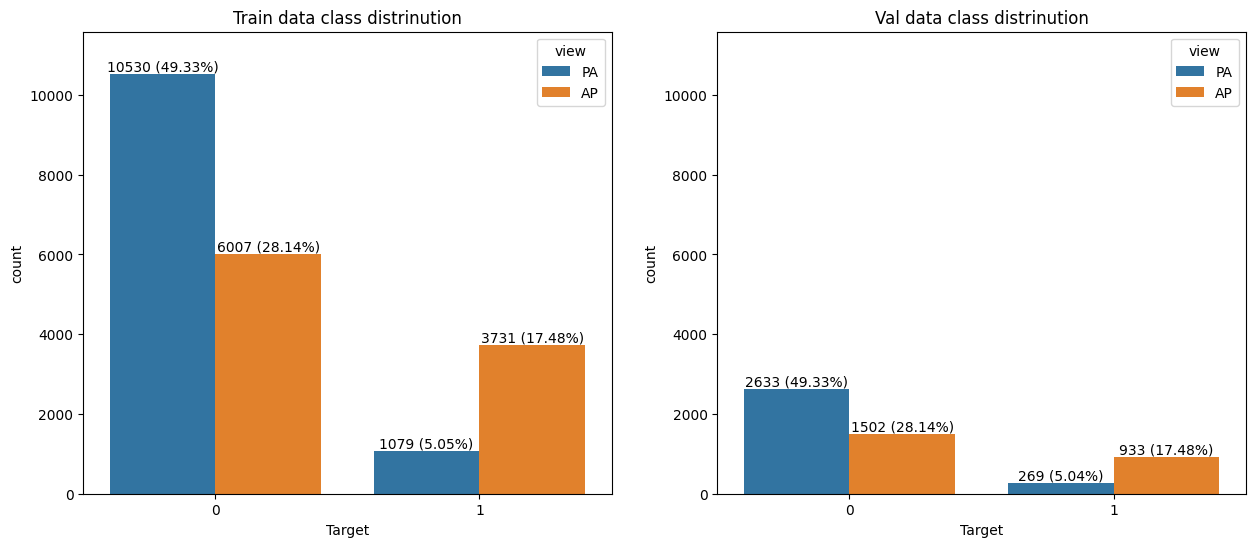

In [39]:
train_value_count = train_df.stratify_group.value_counts()
val_value_count = val_df.stratify_group.value_counts()

# Plot the distribution in graph and plot as percentage

fig, axes= plt.subplots(1, 2, figsize=(15, 6))


# bar graph 1
train_stratify_count = train_df.groupby('Target')['view'].value_counts()
train_stratify_count = pd.DataFrame(data={'count': train_stratify_count.values}, index=train_stratify_count.index).reset_index()

bar1 = sns.barplot(data=train_stratify_count, x='Target', y='count', hue='view', ax=axes[0])
bar1_total = train_stratify_count['count'].sum()

for container in bar1.containers:
    bar1.bar_label(container, labels=[f'{int(h.get_height())} ({int(h.get_height())/bar1_total * 100 :.2f}%)' for h in container])
axes[0].set_title('Train data class distrinution')
axes[0].set_ylim(0, 1.1 * max(train_stratify_count['count']))



# bar graph 2
val_stratify_count = val_df.groupby('Target')['view'].value_counts()
val_stratify_count = pd.DataFrame(data={'count': val_stratify_count.values}, index=val_stratify_count.index).reset_index()

bar2 = sns.barplot(data=val_stratify_count, x='Target', y='count', hue='view', ax=axes[1])
bar2_total = val_stratify_count['count'].sum()

for container in bar2.containers:
    bar2.bar_label(container, labels=[f'{int(h.get_height())} ({int(h.get_height())/bar2_total * 100 :.2f}%)' for h in container])
    # bar2.bar_label(container, fmt='%d')
axes[1].set_title('Val data class distrinution')
axes[1].set_ylim(0, 1.1 * max(train_stratify_count['count']))



In [40]:
### We now have a stratitifed train and val dataset on the basis of Target class and view class 

### Format the data to pass into the YOLOv8

In [51]:
def dcm_to_jpg(dcm_path, save_path):
    '''
    Convert a DICOM (.dcm) file to a JPEG (.jpg) file and save it.

    This function reads a DICOM file from `dcm_path`, converts the pixel data
    to an image, and saves the image as a JPEG file at `save_path`.

    Args:
        dcm_path (str): File path of the input DICOM file.
        save_path (str): File path to save the output JPEG file.

    Returns:
        None
    '''
    save_path = Path(save_path)

    if not save_path.exists():
        dcm_data = dcmread(dcm_path)
        dcm_pixel_array = dcm_data.pixel_array
        image = Image.fromarray(dcm_pixel_array)
        image.save(save_path, 'JPEG')


In [52]:
# Create YOLO File format list

yolo_file_format = ['YOLO_format_data', ['images', 'labels', 'data.yaml'], ['train', 'val']]

# Create the YOLO file format directory
for x in range(2):
    for y in range(2):
        form_path = os.path.join(yolo_file_format[0], yolo_file_format[1][x], yolo_file_format[2][y])
        form_path = Path(form_path)
        form_path.mkdir(parents=True, exist_ok=True)

# # Create data.yaml file
yaml_file = Path(yolo_file_format[0]) / yolo_file_format[1][2]

# Content for the data.yaml file as required by the YOLO model
yaml_content = {
    'train': f'{yolo_file_format[1][0]}/{yolo_file_format[2][0]}',
    'val': f'{yolo_file_format[1][0]}/{yolo_file_format[2][1]}',
    'nc': 1,
    'names': ['pneumonia']
}

# write the content into the data.yaml file
with open(yaml_file, 'w') as file:
    yaml.dump(yaml_content, file)

In [53]:
# function to save all the train val images into the specified direcotry

def save_image(patient_Id, save_file_path):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{patient_Id}.dcm'
    save_file = save_file_path / f'{patient_Id}.jpg'
    dcm_to_jpg(dcm_path=dcm_file_path, save_path=save_file)

In [54]:
x = pd.Series([1, 2, 3, 4, 5])

with ThreadPoolExecutor() as executor:
    square = list(executor.map(lambda item: (item*item), x))

square

[1, 4, 9, 16, 25]

In [59]:
train_yolo_img = Path('YOLO_format_data/images/train')
val_yolo_img = Path('YOLO_format_data/images/val')

train_patientIds = train_df['patientId']
val_patientIds = val_df['patientId']

We will use Multi Threading to compute the "converting dcm data into image file" task faster

by doing this we creates a thread pool, meaning:

Multiple threads are launched.

Each thread runs a function (like save_image) independently.

Threads share the same memory space, so it’s lightweight for I/O-heavy tasks (like reading/writing files).

In [ ]:
# executor.map returns a lazy iterator, so we wrap it in list() to force execution
# and allow tqdm to track progress as each task completes.

with ThreadPoolExecutor() as executor:
    # save all the train data images
    list(tqdm(executor.map(lambda Id: save_image(Id, save_file_path=train_yolo_img), train_patientIds), total=len(train_patientIds)))

    # save all the val data images
    list(tqdm(executor.map(lambda Id: save_image(Id, save_file_path=val_yolo_img), val_patientIds), total=len(val_patientIds)))

100%|██████████| 5337/5337 [00:00<00:00, 15668.55it/s]


In [ ]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [ ]:
# Create a list of all the txt files names for train labels file

train_image_txt_list = []

for image_name in train_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    train_image_txt_list.append(txt_fil_name)

In [ ]:
# File path to save the train labels file to
labels_train = Path('YOLO_format_data/labels/train')


# Iterate over each path from the list of training data path
for index, path in enumerate(yolo_train_path):

    # Patient Id of the instance of data 
    id = path.stem
    # Get all the label data associated with the Id
    bbox_data = label_csv[label_csv['patientId'] == id] 

    # final file path to save the instance of label data to
    labels_train_txt = os.path.join(labels_train, train_image_txt_list[index])

    # Create a  label file for each image data
    with open(labels_train_txt, 'w') as f:
        # write label into the file if the bbox for the image exists 
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

In [ ]:
# Create a list of all the txt files names for val labels file

val_image_txt_list = []

for image_name in val_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    val_image_txt_list.append(txt_fil_name)

In [ ]:
labels_val = Path('YOLO_format_data/labels/val')

x = 0
for index, path in enumerate(val_path):
    id = path.stem
    bbox_data = label_csv[label_csv['patientId'] == id]

    labels_train_txt = os.path.join(labels_val, val_image_txt_list[index])

    with open(labels_train_txt, 'w') as f:
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

    # break
    

### Data Augmentation
### Address the Class Imbalance

In [ ]:
### The pneumonia-absent(0) class data is way higher then the pneumonia-present(1) class....
### There is data class imabalnce and we will address and solve this with heavy augmentation of the peumonia-present(1) class images...and make both the class data to be of equal numbers....

# use Albumentations library for image augmentaiton.....has built in support for bbox....the bbox data is also given when image are augmented 

### Workign with the data part is done...now fine tuning the model part


In [ ]:
from ultralytics import YOLO

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = YOLO('yolov8n.pt')

In [ ]:
train_results = model.train(
    data='YOLO_format_data/data.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    name='medical_imaging'
)

In [ ]:
# Cheked one image of the data and it was in shape of 1024*1024 so a loop to check if all the image are also in 1024*1024 or not

# len(yolo_train_path)
# x = dcmread(yolo_train_path[3])
# shape = x.pixel_array.shape
# for x in shape:
#     print(x)


# for index, path in enumerate(yolo_train_path):
#     data = dcmread(path)
#     image_shape = data.pixel_array.shape
#     for x in image_shape:
#         if x != 1024:
#             print(index)
#             break

1024
1024


In [ ]:
from ultralytics import YOLO

# # Instanciate a new training 
# model = YOLO('runs/detect/medical_imaging_v4/weights/best.pt')
# model.train(data='YOLO_format_data/data.yaml', epochs=50, project='runs/detect', name='medical_imaging_50_epo')


# Continue Training
model = YOLO('runs/detect/medical_imaging_50_epo/weights/last.pt')
# model.train(resume=True)

In [ ]:
model.val()

Ultralytics 8.3.146  Python-3.12.3 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


FileNotFoundError: 'YOLO_format_data/data.yaml' does not exist

### Evaluate the model results and make necessary changes

### Model evaluation metrics.......and graphs to evaluate the model performance post training....